# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load WCPFC and ENSO time series data

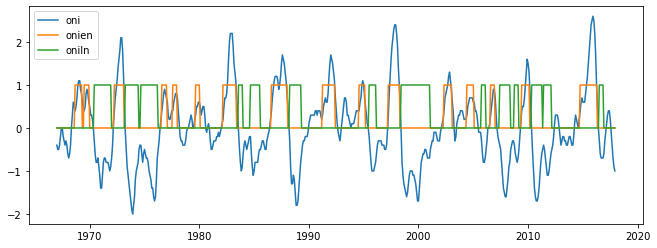

In [2]:
%run wcpfc_load_and_calc.ipynb

# Load environmental variable data

In [5]:
%run load_env_vars.ipynb

# Load extra packages/functions

In [6]:
from scipy.stats import pearsonr

# Question 3? from 9/19/19 in written lab notebook

In [33]:
#https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f

In [7]:
btosds = bettoskj_cp_tot.to_dataset(name='bettoskj_cp_tot')
btosds['skjcptot'] = skj_cp_tot
btosds['betcptot'] = bet_cp_tot
btosds['sst'] = sst
btosds['temp100avg'] = temp0to100avg
btosds['sss'] = sss
btosds['o2100'] = o2100
btosds['po2100avg'] = po20to100avg
btosds['mld'] = mld
btosds['ssha'] = ssha
btosds['logchl'] = logchl
btosds['thd'] = thd
btosds['tcd'] = tcd
df = btosds.to_dataframe()
df.drop(columns=['depth'], inplace=True)
df.rename(columns = {'bettoskj_cp_tot':'b2scptot'}, inplace=True)

### Look for correlation btwn predictors 

In [8]:
def calculate_pvalues(df):
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    #print(pvalues)
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            if c == r:
                pvalues[r][c] = 0
            else:
                df_corr = df[[r,c]].dropna()
                if len(df_corr[r])>2 and len(df_corr[c])>2:
                    pvalues[r][c] = pearsonr(df_corr[r], df_corr[c])[1]
    return pvalues

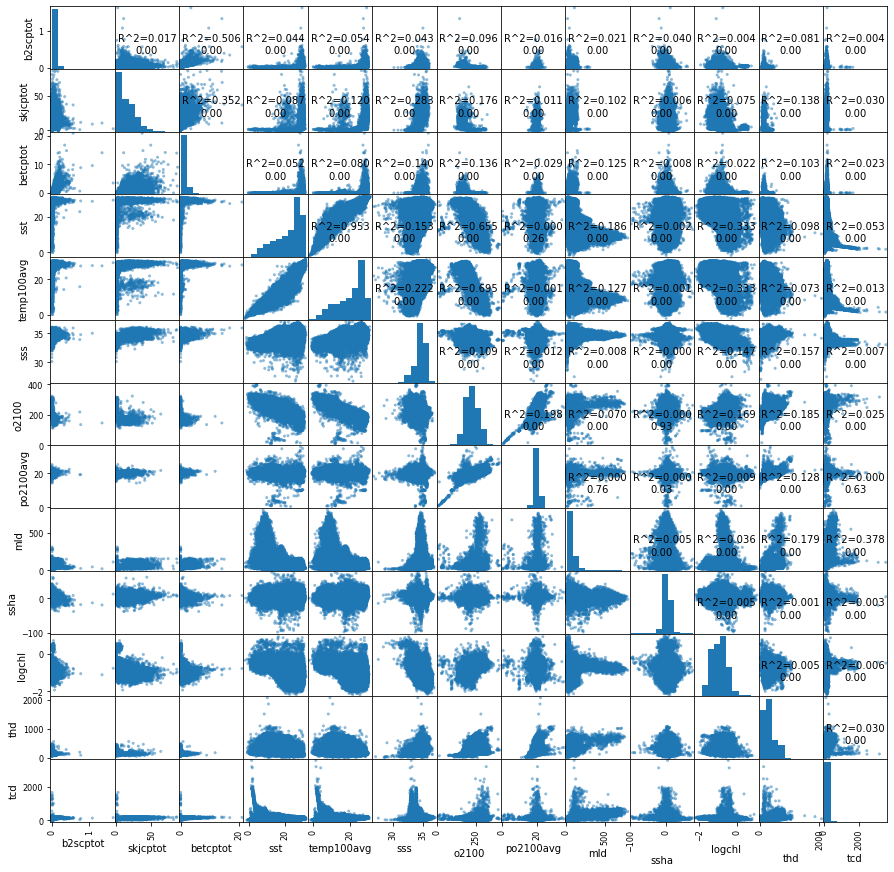

In [9]:
axes = pd.plotting.scatter_matrix(df, alpha = 0.5, figsize = (15,15), diagonal='hist');
corrnow = df.corr().as_matrix()
pvalnow = calculate_pvalues(df).as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("R^2=%.3f" %corrnow[i,j]**2, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
    axes[i, j].annotate("%.2f" %pvalnow[i,j], (0.5, 0.3), xycoords='axes fraction', ha='center', va='center')
fig.savefig(figpath + 'question3_spmatrix_IVs.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

Collinearity btwn environmental variables is high when R^2 > abs(0.6) (Arrizabalaga et al., 2015).  
So there's high collinearity between sst and temp100avg (0.953), sst and o2100 (0.655), and temp100avg and o2100 (0.695).

### Check whether CPUE observations are normal/log normal

In [78]:
df['lbetcptot']=np.log(df['betcptot']+0.1)
df['lskjcptot']=np.log(df['skjcptot']+0.1)
df['lb2scptot']=np.log(df['b2scptot']+0.1)

0.0
20.894766


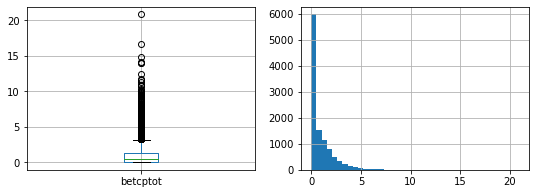

In [71]:
print(df['betcptot'].min())
print(df['betcptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['betcptot'], ax=axes[0])
df['betcptot'].hist(bins=40, ax=axes[1]);

-2.3025851
3.0442731


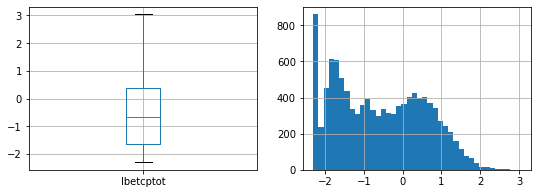

In [79]:
print(df['lbetcptot'].min())
print(df['lbetcptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['lbetcptot'], ax=axes[0])
df['lbetcptot'].hist(bins=40, ax=axes[1]);

0.0
87.07092


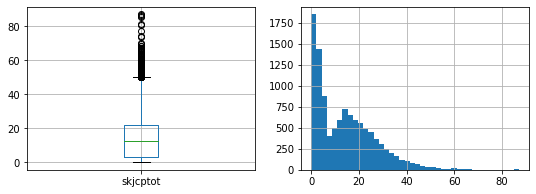

In [72]:
print(df['skjcptot'].min())
print(df['skjcptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['skjcptot'], ax=axes[0])
df['skjcptot'].hist(bins=40, ax=axes[1]);

-2.3025851
4.4678707


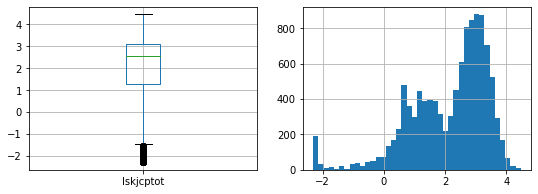

In [80]:
print(df['lskjcptot'].min())
print(df['lskjcptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['lskjcptot'], ax=axes[0])
df['lskjcptot'].hist(bins=40, ax=axes[1]);

0.0
1.6368618


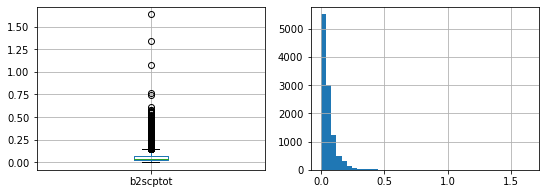

In [70]:
print(df['b2scptot'].min())
print(df['b2scptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['b2scptot'], ax=axes[0])
df['b2scptot'].hist(bins=40, ax=axes[1]);

-2.3025851
0.5520799


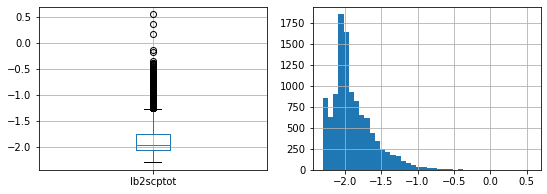

In [81]:
print(df['lb2scptot'].min())
print(df['lb2scptot'].max())
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
df.boxplot(column=['lb2scptot'], ax=axes[0])
df['lb2scptot'].hist(bins=40, ax=axes[1]);

### Check how much data there is

<xarray.DataArray 'skj_cp_tot' ()>
array(108)


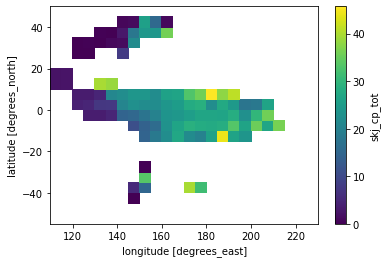

In [116]:
print(skj_cp_tot.mean(dim='time').count())
skj_cp_tot.mean(dim='time').plot();

<xarray.DataArray 'sst' ()>
array(480)
Coordinates:
    depth    float32 0.0


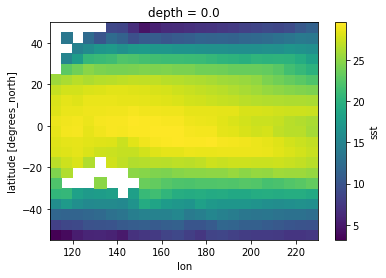

In [142]:
print(btosds['sst'].mean(dim='time').count())
btosds['sst'].mean(dim='time').plot();

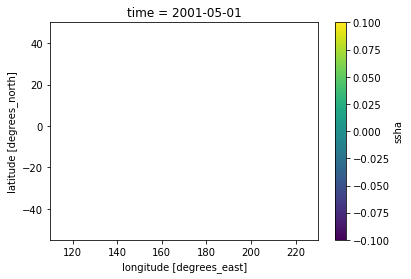

In [165]:
#ssha.mean(dim='time').plot()
ssha.isel(time=100).plot()

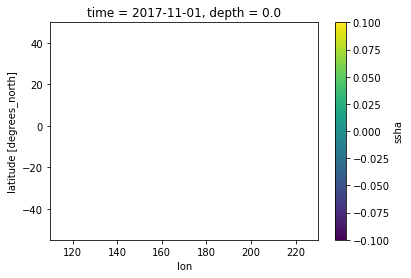

In [157]:
btosds['ssha'].isel(time=610).plot();

In [104]:
for col in df.columns:
    print(col + ': ' + str(len(df[col].dropna())))

b2scptot: 10855
skjcptot: 10973
betcptot: 10973
sst: 182489
temp100avg: 187511
sss: 96522
o2100: 24657
po2100avg: 26501
mld: 107760
ssha: 445
logchl: 99596
thd: 22109
tcd: 166044
lbetcptot: 10973
lskjcptot: 10973
lb2scptot: 10855


In [163]:
from pygam.datasets import wage
X, y = wage()
from pygam import LinearGAM, s, f
gam = LinearGAM(s(0)).fit(X, y)

In [164]:
X.shape

(3000, 3)

In [165]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.9952
Link Function:                     IdentityLink Log Likelihood:                                -25134.4305
Number of Samples:                         3000 AIC:                                            50284.8514
                                                AICc:                                           50284.8995
                                                GCV:                                             1742.5809
                                                Scale:                                           1735.2686
                                                Pseudo R-Squared:                                   0.0054
Feature Function                  Lam

In [166]:
lam = np.logspace(-3, 5, 5)
lams = [lam] * 3

In [169]:
lam

array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05])

In [170]:
gam.gridsearch(X, y, lam=lam)
gam.summary()

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.3737
Link Function:                     IdentityLink Log Likelihood:                                -25132.7976
Number of Samples:                         3000 AIC:                                            50272.3425
                                                AICc:                                           50272.3523
                                                GCV:                                             1736.7963
                                                Scale:                                           1734.3229
                                                Pseudo R-Squared:                                   0.0044
Feature Function                  Lam

In [171]:
gam.terms

s(0) + intercept

In [110]:
X = df.to_numpy()[:,1:10]
y = df.to_numpy()[:,0]
X = X[~np.isnan(y),:]
y = y[~np.isnan(y)]

In [111]:
X[]

array([18.14100075, 16.54100037, 18.79850006, ..., 16.08781815,
               nan, 17.50060081])

In [109]:
X[0:1000,:]

array([[100.        ,          nan,  18.14100075, ...,          nan,
                 nan,          nan],
       [100.        ,          nan,  16.54100037, ...,          nan,
                 nan,          nan],
       [100.        ,          nan,  18.79850006, ...,  91.52867889,
         35.5625    ,          nan],
       ...,
       [100.        ,          nan,  28.61131287, ..., 211.25588989,
         35.35656357,          nan],
       [100.        ,          nan,  28.85530472, ..., 213.87054443,
         35.22514725,          nan],
       [100.        ,          nan,  29.55988312, ..., 175.62597656,
         35.0384407 ,          nan]])

In [104]:
from pygam import LinearGAM, s, f
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8))
gam.gridsearch(X, y)

ValueError: X data must not contain Inf nor NaN

In [28]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage
X, y = wage(return_X_y=True)

In [37]:
X.shape

(3000, 3)

In [38]:
y.shape

(3000,)

In [32]:
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 432x288 with 0 Axes>

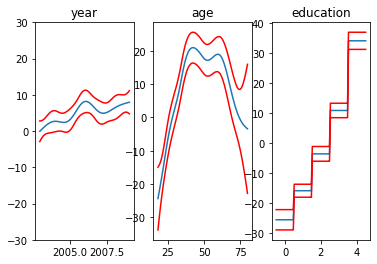

In [44]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,3);
titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [45]:
gam = LinearGAM(s(0) + s(1) + s(2))
gam.gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 432x288 with 0 Axes>

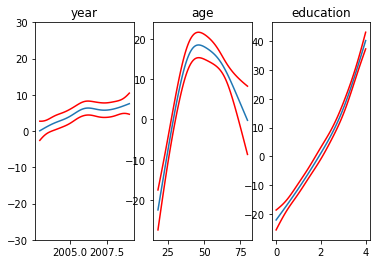

In [46]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,3);
titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [41]:
from pygam import LinearGAM, s, f
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
target_df = pd.Series(boston.target)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [42]:
X = df
y = target_df

In [43]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
dtype: float64

In [44]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [45]:
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [33]:
gam = LinearGAM(n_splines=10).gridsearch(X, y)
gam.summary()

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [34]:
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
#load the breast cancer data set
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [35]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df

In [36]:
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [37]:
#gam = LogisticGAM().fit(X,y)
# default params are n_splines=25, lam=0.6, constraints=None
lambda_ = 0.6
# lambda controls how much we penalize "wiggliness", so even
# w/ a large value for n_splines, could get straight line if
# lambda is large enough
n_splines = [25, 6, 25, 25, 6, 4]
# number of splines to use in each of the smooth functions
# to be fitted
constraints = None
gam = LogisticGAM(constraints=constraints, 
          lam=lambda_,
         n_splines=n_splines).fit(X, y)

In [38]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     11.0758
Link Function:                        LogitLink Log Likelihood:                                   -65.0026
Number of Samples:                          569 AIC:                                              152.1568
                                                AICc:                                             152.7248
                                                UBRE:                                                2.283
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.827
Feature Function                  Lam

In [39]:
gam.accuracy(X,y)

0.9507908611599297

In [ ]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i+1)
    pdep, confi = gam.partial_dependence(term=i+1, X=XX, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])

In [ ]:
gam = LogisticGAM().gridsearch(X,y)
# gridsearch() creates a grid to search over smoothing
# params

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gam = LogisticGAM().gridsearch(X_train, y_train)

In [ ]:
#https://buildmedia.readthedocs.org/media/pdf/pygam/latest/pygam.pdf

# Old

In [ ]:
# prof with temp values
ilat=17; ilon=20; itime=507;

In [ ]:
# get only profiles where deepest measurement is >100 m and shallowest measurement is <10 m
deepestnonnandepth = po2['depth'][~np.isnan(po2).argmax(dim='depth')]
tempprofnow[~np.isnan(tempprofnow)]
didxdeep = np.argmax(tempprofnow<=ttcnow).values

deepestnonnandepth = po2['depth'][~np.isnan(po2).argmax(dim='depth')]

po2.sel(depth=slice(0,100)).integrate('depth')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
po2.sel(lat=2.5, lon=102.5).plot(x='time',yincrease=False, ax=axes[0])
axes[0].set_ylim(100,0)
cont=po2.sel(lat=2.5, lon=102.5).plot.contour(x='time',levels=[15],yincrease=False, ax=axes[1])
axes[1].set_ylim(100,0)

In [ ]:
#https://gist.github.com/aidanheerdegen/11451b280d7e07a8f4c078820908ab4a
cont = None
cont = po2.sel(lat=2.5, lon=102.5).plot.contour(x='time',levels=[15],yincrease=False)
val = {}
for path in cont.collections[0].get_paths():
    for (x,y),s in path.iter_segments():
        val[x] = y
        #print(x,y)
        #print(val)
tmp = xr.DataArray(list(val.values()),dims=['time'],coords={'time':list(val.keys())})
print(tmp)
#isotherm[i,:] = tmp.interp(i=ds.i)